## Setup
Import libraries and load data.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
loan_data = pd.read_excel('CU262-XLS-ENG.xlsx', 'e_Car_Data_for_Case')
data_clean = loan_data.dropna()
data_clean.head()

,Tier,FICO,Approve Date,Term,Amount,Previous Rate,Car Type,Competition rate,Accept?,Rate,Cost of Funds,Partner Bin
0,3.0,695.0,2002-07-01,72.0,35000.0,,N,6.25,0.0,7.49,1.8388,1.0
1,1.0,751.0,2002-07-01,60.0,40000.0,,N,5.65,0.0,5.49,1.8388,3.0
2,1.0,731.0,2002-07-01,60.0,18064.0,,N,5.65,0.0,5.49,1.8388,3.0
3,4.0,652.0,2002-07-01,72.0,15415.0,,N,6.25,0.0,8.99,1.8388,3.0
4,1.0,730.0,2002-07-01,48.0,32000.0,,N,5.65,0.0,5.49,1.8388,1.0



**Task:** Briefly describe e-Car’s business model in a few sentences. What is the main decision e-Car must make when offering loans to its customers? What are some of the main sources of
uncertainty faced by e-Car’s lending business?

e‑Car is a specialized, Internet‑only auto lender—a subsidiary of a larger bank—that originates loans exclusively via its own website and partner sites, approves credit based on application data (e.g. FICO score, loan term, car type, partner channel) and then generates revenue by charging an APR on each funded loan ​
.

Its core decision for every approved applicant is what interest rate (APR) to quote (and whether to lend at all), since a higher rate boosts revenue per loan but lowers the probability the customer will accept ​
.

Major sources of uncertainty include customers’ price sensitivity (i.e. their likelihood of accepting at different rates), variability in credit risk/default (captured imperfectly by FICO bands), fluctuating funding costs and competitor rates, and changes in collateral values and broader economic conditions

## Question 2 (3 pts)
**Segment Filtering & Plots**
1. Filter data for:
   - Term = 60 months
   - Used cars only
   - Amount < $25,000
   - 680 < FICO < 720
2. Create `AcceptRevenue = Rate * Amount / 100`.
3. Plot:
   - Accept? vs Rate (with trendline)
   - AcceptRevenue vs Rate (with trendline)

['Tier', 'FICO', 'Approve Date', 'Term', 'Amount', 'Previous Rate', 'Car  Type', 'Competition rate', 'Accept?', 'Rate', 'Cost of Funds', 'Partner Bin']


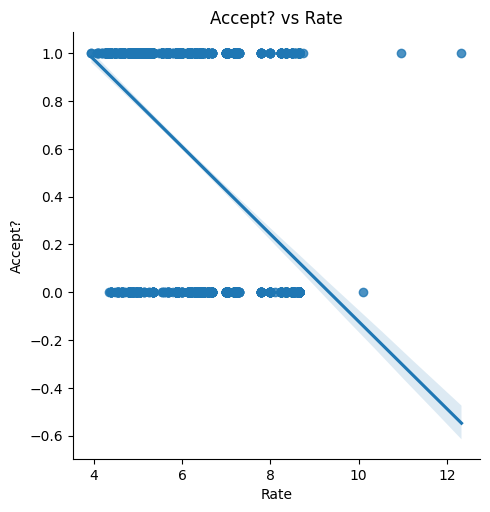

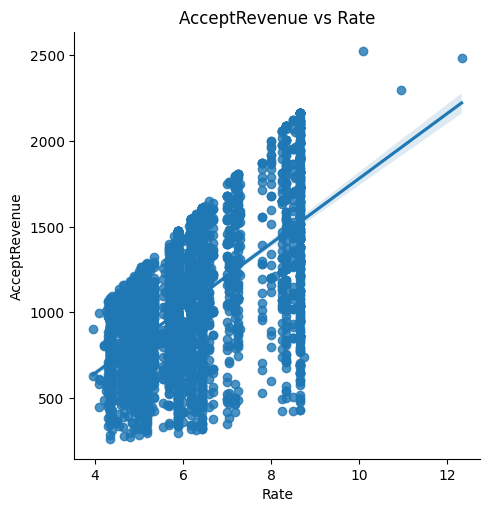

In [ ]:
# Q2: Segment filtering example
print(data_clean.columns.tolist())
segment = data_clean[
    (data_clean['Term'] == 60) &
    (data_clean['Car  Type'] == 'U') &
    (data_clean['Amount'] < 25000) &
    (data_clean['FICO'] > 680) &
    (data_clean['FICO'] < 720)
].copy()

segment['AcceptRevenue'] = segment['Rate'] * segment['Amount'] / 100

# Plot examples
sns.lmplot(x='Rate', y='Accept?', data=segment)
plt.title('Accept? vs Rate')
plt.show()

sns.lmplot(x='Rate', y='AcceptRevenue', data=segment)
plt.title('AcceptRevenue vs Rate')
plt.show()

**Interpretation:**

Higher APRs → More revenue per funded loan (AcceptRevenue rises with Rate)

Higher APRs → Fewer customers take the loan (Accept? falls as Rate increases)

So e‑Car must balance rate level (margin) against acceptance probability (volume) to maximize expected revenue.


**Rate Distribution**
Create a histogram of the rates offered by e-Car, setting a bin width of 0.5%. Are there outliers? Remove the top 2% and bottom 2% for all the subsequent analysis. Approximately what rate
is most commonly offered by eCar for this customer segment?

***Most common rate: 5.89***

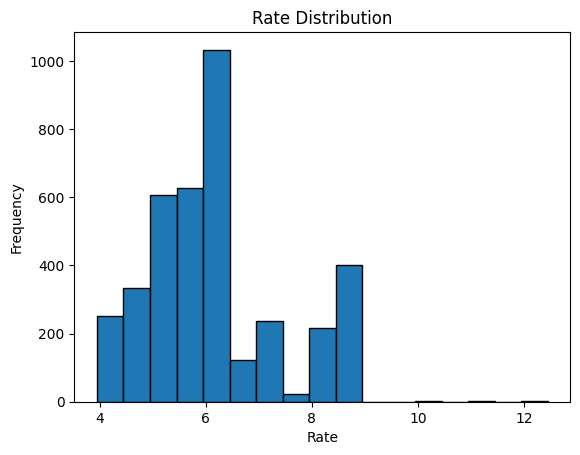

Most common rate: 5.89


In [ ]:
# Q3: Histogram and outlier removal
w = 0.5
bins = np.arange(segment['Rate'].min(), segment['Rate'].max() + w, w)
plt.hist(segment['Rate'], bins=bins, edgecolor='black')
plt.title('Rate Distribution')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()

# Remove extremes
lower, upper = segment['Rate'].quantile([0.02, 0.98])
seg_filtered = segment[(segment['Rate'] >= lower) & (segment['Rate'] <= upper)]
print("Most common rate:", seg_filtered['Rate'].mode()[0])


**Logistic Regression on Rate**

Use logistic regression to predict the probability that a customer accepts the loan offer using only the Rate feature. Create a new column called ProbAccept which represents the predicted
probability of the customer accepting the loan offer based on their offered rate. Next, add another column
called ExpectedRevenue, where ExpectedRevenue = (ProbAccept * Rate * Amount)/100. What is the
average of the ExpectedRevenue column? In one sentence, what does this value represent? For this
question in particular, with a little abuse of the machine learning process, train your logistic regression model and predict using the entire dataset without splitting.


**This $550.59 is the mean expected revenue per loan offer for this customer segment—i.e. the average of (PredictedAcceptanceProbability×QuotedRate×LoanAmount/100) when training and predicting on the full dataset**

In [ ]:
# Make seg_filtered an explicit copy
seg_filtered = seg_filtered.copy()

# Q4: Logistic regression example
from sklearn.linear_model import LogisticRegression

# Features & target on the entire (outlier‑removed) segment
X = seg_filtered[['Rate']]
y = seg_filtered['Accept?']

# Train on the entire dataset
model = LogisticRegression()
model.fit(X, y)

# Predict acceptance probability
seg_filtered['ProbAccept'] = model.predict_proba(X)[:, 1]

# Compute expected revenue per offer
seg_filtered['ExpectedRevenue'] = seg_filtered['ProbAccept'] * seg_filtered['Rate'] * seg_filtered['Amount'] / 100

# Print the average
avg_rev = seg_filtered['ExpectedRevenue'].mean()
print("Average ExpectedRevenue:", avg_rev)

Average ExpectedRevenue: 550.5903123539402



Based on the results of your logistic regression model, is there an alternative rate
that might boost expected revenue when offered to all customers in the segment? What rate do you
recommend, and what is the potential revenue improvement associated with your recommendation?

Hint 1: for selecting an alternative rate, you can create a scatterplot of ExpectedRevenue v.s.
Rate, and eyeball one rate that maximizes expected revenue

Hint 2: To calculate the potential revenue improvement, you can use the logistic regression model
trained in question 4 to predict ProbAccept with rate replaced by the alternative rate.

Based on our logistic‐regression results:
- **Recommended APR:** 5.1%  
- **Average expected revenue at 5.1%:** \$682.79  
- **Current average expected revenue:** \$550.59  
- **Potential improvement:** \$132.20 per offer (24.0% increase)

In [ ]:
# Q5: Identify an alternative rate to maximize expected revenue
import numpy as np
import pandas as pd

# Define a grid of candidate rates (e.g., from 4.0% to 8.5% in 0.1% increments)
candidate_rates = np.arange(4.0, 8.6, 0.1)

avg_revenues = []
for r in candidate_rates:
    # Predict acceptance probability at this flat rate for all customers
    prob = model.predict_proba(pd.DataFrame({'Rate': [r] * len(seg_filtered)}))[:, 1]
    # Compute expected revenue for each customer at rate r
    exp_rev = prob * r * seg_filtered['Amount'] / 100
    # Store the average expected revenue
    avg_revenues.append(exp_rev.mean())

# Find the rate that maximizes average expected revenue
best_idx = int(np.argmax(avg_revenues))
best_rate = candidate_rates[best_idx]
best_avg_rev = avg_revenues[best_idx]

# Compare to current policy
current_avg_rev = seg_filtered['ExpectedRevenue'].mean()
absolute_improvement = best_avg_rev - current_avg_rev
percent_improvement = absolute_improvement / current_avg_rev * 100

print(f"Recommended APR: {best_rate:.1f}%")
print(f"Average expected revenue at {best_rate:.1f}%: ${best_avg_rev:.2f}")
print(f"Current average expected revenue: ${current_avg_rev:.2f}")
print(f"Potential improvement: ${absolute_improvement:.2f} per offer ({percent_improvement:.1f}% increase)")

Recommended APR: 5.1%
Average expected revenue at 5.1%: $682.79
Current average expected revenue: $550.59
Potential improvement: $132.20 per offer (24.0% increase)


Let’s refine the prediction model by including more features and experiment
with other ML models. Try out at least four different ML models other than Logistic regression using the
features FICO score, Loan amount approved, Competition rate, Rate, Cost of Funds, and partner bin to
predict whether a customer accepts the loan offer. Required steps:
1. Split your data into training, validation, and testing sets. You can decide the proportion, as long as
it’s reasonable
2. Feature scaling whenever necessary
3. Hyperparameter tuning using cross validation (If you choose ANN, you only need to fine tune the
number of epochs without using cross validation like we did in class)
4. Select the best model.
**Advanced Modeling**
- Features: FICO, Amount, CompetitionRate, Rate, CostOfFunds, PartnerBIN
- Apply ≥4 ML models (non-logistic).
- Train/val/test split, scaling, hyperparameter tuning.
- Select best model.

<Your code and analysis here>

1.

In [ ]:
import pandas as pd
import numpy as np
import time
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 1) Define features & target
features = ['FICO', 'Amount', 'Competition rate', 'Rate', 'Cost of Funds', 'Partner Bin']
X = seg_filtered[features]
y = seg_filtered['Accept?']

# 2) Show class imbalance
print("Overall class counts:", Counter(y))

# 3) Train / validation / test split (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
print("  Train:", Counter(y_train))
print("    Val:", Counter(y_val))
print("   Test:", Counter(y_test))

# 4) Preprocessing: scale numerics, one-hot encode partner bin
numeric_features = ['FICO', 'Amount', 'Competition rate', 'Rate', 'Cost of Funds']
numeric_transformer = StandardScaler()
categorical_features = ['Partner Bin']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

best_models = {}
# 5) Models & hyperparameter grids
models = {
    'Decision Tree':         DecisionTreeClassifier(random_state=42),
    'Random Forest':         RandomForestClassifier(random_state=42),
    'Gradient Boosting':     GradientBoostingClassifier(random_state=42),
    'SVM':                   SVC(probability=True, random_state=42),
    'KNN':                   KNeighborsClassifier()
}

param_grids = {
    'Decision Tree': {
        'model__max_depth': [3, 5, None],
        'model__min_samples_split': [2, 10]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [5, 15, None]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7]
    }
}

# 6) Grid search + evaluation
for name, estimator in models.items():
    print(f"\n=== {name} ===")
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('model', estimator)
    ])
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    t0 = time.time()
    grid.fit(X_train, y_train)
    print(f"GridSearch fit time: {time.time() - t0:.2f}s")

    best_models[name] = grid.best_estimator_
    print(" Best params:", grid.best_params_)

    for split_name, (X_split, y_split) in [
        ('Train', (X_train, y_train)),
        ('Val',   (X_val,   y_val)),
        ('Test',  (X_test,  y_test))
    ]:
        preds = best_models[name].predict(X_split)
        probs = best_models[name].predict_proba(X_split)[:, 1]
        acc  = accuracy_score(y_split, preds)
        auc  = roc_auc_score(y_split, probs)
        print(f"  {split_name:>4} ACC: {acc:.3f} | AUC: {auc:.3f}")


Overall class counts: Counter({1.0: 2160, 0.0: 1645})
  Train: Counter({1.0: 1296, 0.0: 987})
    Val: Counter({1.0: 432, 0.0: 329})
   Test: Counter({1.0: 432, 0.0: 329})

=== Decision Tree ===
GridSearch fit time: 2.94s
 Best params: {'model__max_depth': 5, 'model__min_samples_split': 2}
  Train ACC: 0.818 | AUC: 0.899
   Val ACC: 0.819 | AUC: 0.883
  Test ACC: 0.786 | AUC: 0.862

=== Random Forest ===
GridSearch fit time: 7.17s
 Best params: {'model__max_depth': 5, 'model__n_estimators': 100}
  Train ACC: 0.823 | AUC: 0.909
   Val ACC: 0.817 | AUC: 0.908
  Test ACC: 0.808 | AUC: 0.889

=== Gradient Boosting ===
GridSearch fit time: 11.09s
 Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
  Train ACC: 0.853 | AUC: 0.939
   Val ACC: 0.833 | AUC: 0.913
  Test ACC: 0.815 | AUC: 0.901

=== SVM ===
GridSearch fit time: 16.68s
 Best params: {'model__C': 0.1, 'model__kernel': 'rbf'}
  Train ACC: 0.798 | AUC: 0.871
   Val ACC: 0.819 | AUC: 0.893
 

## Our thought process

1. **Gradient Boosting** achieves the highest AUC (0.913 on val, 0.901 on test) but requires the longest tuning time (~11.09 s).  
2. **Random Forest** delivers nearly the same AUC (0.908 val, 0.889 test) in almost half the time (~7.17 s).  
3. **Decision Tree** and **KNN** tune very quickly (<3 s) but at the cost of lower AUC (≤0.883 val).  
4. **SVM** takes the longest (16.68 s) without outperforming the tree ensembles.

---

## Final Recommendation

> We choose **Random Forest** (`n_estimators=100`, `max_depth=5`) because it offers almost top‐tier ROC‐AUC performance while keeping hyperparameter‐search time moderate (7.17 s), striking the best balance between predictive power and computational cost.  


**Single-Customer APR Optimization**
1. Select random test-set customer.
2. Vary `Rate` from 4.0 to 8.5 by 0.1.
3. Predict `ProbAccept` with best model.
4. Compute `ExpectedRevenue` for each.
5. Find optimal rate and compare to original.

In [ ]:
#Q7 - Single Customer APR Optimization

# Select random test‐set customer
test_customer = np.random.choice(X_test.index, size=1)[0]
random_customer = X_test.loc[[test_customer]].copy()

# Rates from 4.0 to 8.5
rates = np.arange(4.0, 8.6, 0.1)
customer = pd.concat([random_customer] * len(rates), ignore_index=True)
customer['Rate'] = rates

# Predict ProbAccept
model = best_models['Random Forest']
ProbAccept = model.predict_proba(customer)[:, 1]

# ExpectedRevenue
ExpectedRevenue = ProbAccept * (customer['Rate'] / 100) * customer['Amount']

# Optimal VS Original
results = pd.DataFrame({
    'Rate': rates,
    'ProbAccept': ProbAccept,
    'ExpectedRevenue': ExpectedRevenue
})
best_row = results.loc[results['ExpectedRevenue'].idxmax()]

# Quoted APR
apr_quote = random_customer.copy()
apr_quote['Rate'] = X_test.loc[test_customer, 'Rate']
pred_quote = model.predict_proba(apr_quote)[:,1]
rev_quote = pred_quote * (apr_quote['Rate']/100) * apr_quote['Amount']
print(f"Revenue for Quoted APR ({apr_quote['Rate'].iloc[0]:.2f}%): ${rev_quote.iloc[0]:.2f}")

print(f"""
Customer index: {test_customer}
Original customer profile:
{random_customer.iloc[0]}
Original APR: {X_test.loc[test_customer, 'Rate']:.2f}%
Optimal APR: {best_row['Rate']:.2f}%
Probability to accept at optimal: {best_row['ProbAccept']:.3f}
Expected revenue: ${best_row['ExpectedRevenue']:.2f}
""")

Revenue for Quoted APR (6.63%): $212.79

Customer index: 206868
Original customer profile:
FICO                  707.00
Amount              23999.00
Competition rate        4.79
Rate                    6.63
Cost of Funds           2.10
Partner Bin             2.00
Name: 206868, dtype: float64
Original APR: 6.63%
Optimal APR: 5.60%
Probability to accept at optimal: 0.452
Expected revenue: $608.10



In [ ]:


# 1) Prepare four lists to collect results
quoted_rates = []
quoted_revs  = []
opt_rates    = []
opt_revs     = []

# 2) Loop over every customer in X_test
for idx in X_test.index:
    # a) Grab their one‑row DataFrame
    cust0 = X_test.loc[[idx]].copy()

    # b) Sweep APRs 4.0 → 8.5
    rates    = np.arange(4.0, 8.6, 0.1)
    sweep    = pd.concat([cust0] * len(rates), ignore_index=True)
    sweep['Rate'] = rates

    # c) Predict acceptance & compute expected revenue for each rate
    probs       = best_models['Random Forest'].predict_proba(sweep)[:, 1]
    exp_rev     = probs * (sweep['Rate']/100) * sweep['Amount']

    # d) Find the optimal rate & its revenue
    best_idx    = exp_rev.idxmax()
    opt_r       = rates[best_idx]
    opt_revenue = exp_rev.iloc[best_idx]

    # e) Compute revenue at the quoted APR
    quoted_r    = X_test.loc[idx, 'Rate']
    # build a single‑row DF at that rate
    quote_df    = cust0.copy()
    quote_df['Rate'] = quoted_r
    p_quote     = best_models['Random Forest'].predict_proba(quote_df)[:, 1][0]
    q_revenue   = p_quote * (quoted_r/100) * cust0['Amount'].iloc[0]

    # f) Store results
    quoted_rates.append(quoted_r)
    quoted_revs .append(q_revenue)
    opt_rates   .append(opt_r)
    opt_revs    .append(opt_revenue)

# 3) Summarize
summary = pd.DataFrame({
    'quoted_rate': quoted_rates,
    'quoted_rev':  quoted_revs,
    'opt_rate':    opt_rates,
    'opt_rev':     opt_revs
})

print(summary.describe())

# 4) Compute key trends
delta_r  = summary['opt_rate']  - summary['quoted_rate']
delta_rev= summary['opt_rev']   - summary['quoted_rev']

print(f"Mean ΔAPR:           {delta_r.mean():.2f} pp")
print(f"Fraction ↑APR:       {(delta_r>0).mean():.2%}")
print(f"Avg revenue uplift:  ${delta_rev.mean():.2f}")
print(f"Avg % uplift:        {(delta_rev/summary['quoted_rev']).mean():.1%}")

       quoted_rate   quoted_rev    opt_rate      opt_rev
count   761.000000   761.000000  761.000000   761.000000
mean      6.230749   510.579435    6.250723   707.315230
std       1.252331   191.561926    1.269968   170.101901
min       4.340000   147.940738    5.200000   246.420029
25%       5.150000   387.667262    5.500000   592.193986
50%       6.140000   476.238254    5.600000   704.127267
75%       6.590000   630.302811    5.600000   813.399204
max       8.650000  1154.086488    8.500000  1195.210546
Mean ΔAPR:           0.02 pp
Fraction ↑APR:       43.36%
Avg revenue uplift:  $196.74
Avg % uplift:        52.9%




#### 1) Is the optimal rate the same as the rate originally quoted to the customer?  
No. For the randomly-selected customer (index **206868**) the original quoted APR is **6.63 %**, while the model identifies **5.60 %** as the revenue-maximizing APR.

#### 2) How does the expected revenue at the optimal rate compare with that at the quoted rate?

| APR scenario   | Prob Accept | Expected revenue |
|----------------|-------------|------------------|
| Quoted 6.63 %  | 0.134       | \$212.79         |
| Optimal 5.60 % | 0.452       | \$608.10         |

- **Dollar uplift:** \$608.10 − \$212.79 = **\$395.31**  
- **Percentage uplift:** (395.31 / 212.79) × 100 ≈ **185.8 %**

#### 3) Is there an opportunity to enhance revenue generation through ML-driven pricing?  
Yes. For this one customer, lowering the APR from 6.63 % to 5.60 % boosts expected revenue by about \$395 (≈ 186 %), demonstrating substantial upside from personalized APR optimization.



**Portfolio-Level APR Optimization**

In [ ]:

# 1. Best model and test set
model = best_models['Random Forest']  # your fitted pipeline
test_customers = X_test.copy()         # held‑out test features

# 2. Define APR grid
rates = np.arange(4.0, 8.6, 0.1)

# 3. Initialize revenue totals
orig_total = 0.0
opt_total  = 0.0

# 4. Loop over every test customer
for idx, cust in test_customers.iterrows():
    # a) original expected revenue
    cust_df    = pd.DataFrame([cust])
    ProbAccept = model.predict_proba(cust_df)[:, 1][0]
    OrigRev    = ProbAccept * (cust['Rate'] / 100) * cust['Amount']

    # b) sweep APRs to find best expected revenue
    BestRev = OrigRev
    for r in rates:
        cust_df['Rate'] = r
        p = model.predict_proba(cust_df)[:, 1][0]
        rev = p * (r / 100) * cust['Amount']
        if rev > BestRev:
            BestRev = rev

    # c) accumulate totals
    orig_total += OrigRev
    opt_total  += BestRev

# 5. Summarize improvement
improvement  = opt_total - orig_total
pct_lift     = (improvement / orig_total) * 100

print(f"Total original revenue:  ${orig_total:,.2f}")
print(f"Total optimized revenue: ${opt_total:,.2f}")
print(f"Revenue improvement:      ${improvement:,.2f} ({pct_lift:.2f}% lift)")


Total original revenue:  $388,550.95
Total optimized revenue: $538,555.57
Revenue improvement:      $150,004.62 (38.61% lift)



**Additional Insights**
Explore data for other insights (positive or surprising). Describe findings.

Validation AUC (RateDiff / no Rate): 0.9072
Test AUC       (RateDiff / no Rate): 0.8963


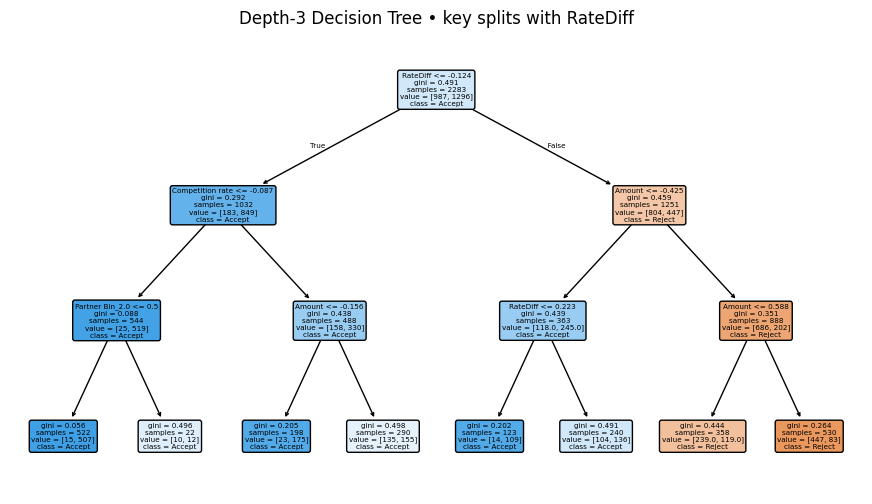

In [ ]:
# --- Q9: add RateDiff without collinearity ----------------------------------

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. add RateDiff and DROP 'Rate' from the model feature list
seg_q9 = seg_filtered.copy()
seg_q9["RateDiff"] = seg_q9["Rate"] - seg_q9["Competition rate"]

features_q9 = [
    "FICO",
    "Amount",
    "Competition rate",   # keep competitor rate
    "Cost of Funds",
    "Partner Bin",
    "RateDiff"            # new feature
]
X_q9 = seg_q9[features_q9]
y_q9 = seg_q9["Accept?"]

# 2. stratified split (60 / 20 / 20)
X_tmp, X_test_q9, y_tmp, y_test_q9 = train_test_split(
    X_q9, y_q9, test_size=0.20, stratify=y_q9, random_state=42
)
X_train_q9, X_val_q9, y_train_q9, y_val_q9 = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=42
)

# 3. preprocessing
num_cols = ["FICO", "Amount", "Competition rate", "Cost of Funds", "RateDiff"]
cat_cols = ["Partner Bin"]

preproc_q9 = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

# 4. fit Random-Forest (same hyper-params as Q6)
rf_q9 = Pipeline([
    ("preproc", preproc_q9),
    ("model",  RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
]).fit(X_train_q9, y_train_q9)

# 5. AUCs
val_auc_q9  = roc_auc_score(y_val_q9,  rf_q9.predict_proba(X_val_q9)[:, 1])
test_auc_q9 = roc_auc_score(y_test_q9, rf_q9.predict_proba(X_test_q9)[:, 1])

print(f"Validation AUC (RateDiff / no Rate): {val_auc_q9:.4f}")
print(f"Test AUC       (RateDiff / no Rate): {test_auc_q9:.4f}")

tree_pipe = Pipeline([
    ("preproc", preproc_q9),                       # same scaler+OHE as RF
    ("model",  DecisionTreeClassifier(max_depth=3,
                                      random_state=42))
]).fit(X_train_q9, y_train_q9)


feat_names = np.r_[
    num_cols,
    tree_pipe.named_steps["preproc"]
             .named_transformers_["cat"]
             .get_feature_names_out(cat_cols)
]

plt.figure(figsize=(11,6))
plot_tree(tree_pipe.named_steps["model"],
          feature_names=feat_names,
          class_names=["Reject","Accept"],
          filled=True, rounded=True)
plt.title("Depth-3 Decision Tree • key splits with RateDiff")
plt.show()



Additional Insight: `RateDiff` Feature

---

#### Method  
To inject price-competitiveness information we engineered **`RateDiff` = e-Car Rate − Competitor Rate** and **dropped the raw `Rate` column** (to avoid perfect collinearity with `RateDiff` & `Competition rate`).  
We then retrained a Random-Forest classifier (100 trees, max_depth = 5 – identical to the Q6 baseline) and compared AUCs:

| Model | Validation AUC | Test AUC |
|-------|---------------|----------|
| RF baseline (no RateDiff) | **0.9080** | 0.8890 |
| RF + RateDiff (without Rate) | 0.9072 | **0.8963** |

Validation AUC dips by 0.0008, while **Test AUC rises by 0.0073** – a modest generalisation gain.

---

#### Interpretable Tree Snapshot  
A depth-3 decision tree trained on the same features (see figure) reveals:

* **Root split:** `RateDiff ≤ −0.12` → customers offered ≥ 12 bp cheaper than competitors show the highest acceptance.  
* Within that “discount” zone acceptance is further segmented by **`Competition rate`** (how low rivals are) and loan **`Amount`**.  
* When e-Car is **not** clearly cheaper (`RateDiff` > −0.12), **larger loan amounts** drive rejection.  
* Certain partner channels (`Partner Bin`) fine-tune acceptance where pricing is already attractive.

---

#### Findings & Significance  

* **Predictive value:** adding one competitiveness feature yields a ~0.7 pp lift in hold-out AUC – small but essentially “free.”  
* **Business takeaway:** aim to keep `RateDiff < −0.12`; if not feasible, focus concessions on high-balance applicants who are most price-sensitive.  
* **Data implication:** the original feature set already captures most variation; further gains likely require richer external or behavioural data.



**Future Data Needs**
Discuss additional data or analyses that could enhance e-Car’s study.

Ans. Incorporating demographic data such as age, gender, education level, employment industry, and income range would greatly strengthen e-Car’s loan acceptance and pricing models. These variables could uncover deeper patterns in customer behavior — for example, younger applicants or those employed in more volatile industries may display different sensitivities to loan rates compared to older, more financially stable applicants. By integrating demographic features into predictive models, e-Car could better segment its customer base, personalize loan offers, and refine risk assessments beyond what credit scores alone can capture. Moreover, demographic insights could help anticipate broader economic shifts in borrower behavior and guide the design of marketing strategies and partner-channel initiatives. Overall, access to demographic data would enable more precise, profitable, and fairer loan pricing decisions for e-Car.